## Time-Series Analysis

In [1]:
reset -sf

In [2]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import norm
import statsmodels.api as sm
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf

/Users/yun/anaconda/envs/stats/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Get GOLD Data & Clean Data

In [3]:
#load the gold adj. price data(1979 ~ 2016) and make index for date as datetime type
gold = pd.read_csv('gold.csv')
gold['Date'] = pd.DatetimeIndex(gold['Date'])
gold = gold.set_index('Date')
gold.head()

,adj_close
Date,
1979-01-01,226.0
1979-01-02,226.8
1979-01-03,218.6
1979-01-04,223.2
1979-01-05,225.5


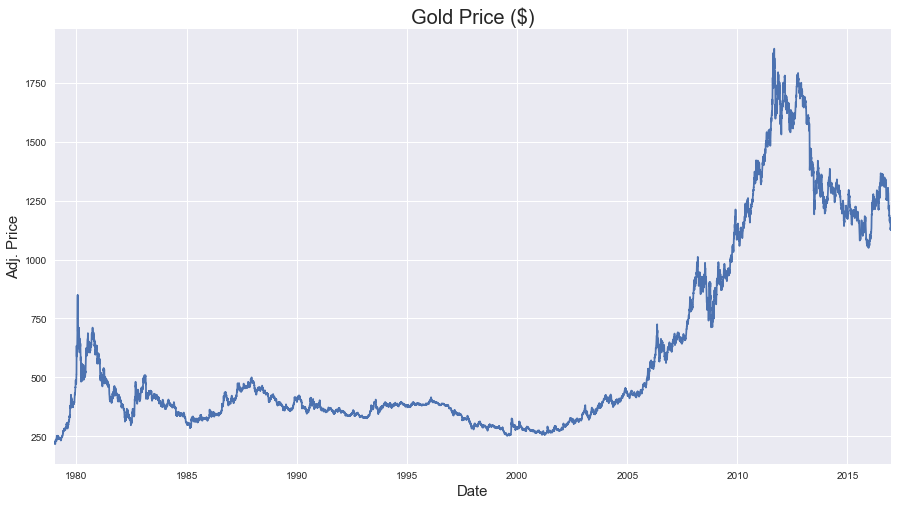

In [4]:
#plot gold price
plt.figure(figsize=(15, 8))
plt.title('Gold Price ($)', fontsize=20)
plt.ylabel('Adj. Price', fontsize=15)
plt.xlabel('Date', fontsize=15)
gold['adj_close'].plot()
plt.show()

In [182]:
#calculate daily gold price change
daily_change = gold['adj_close'].pct_change() * 100
len(daily_change)

9915

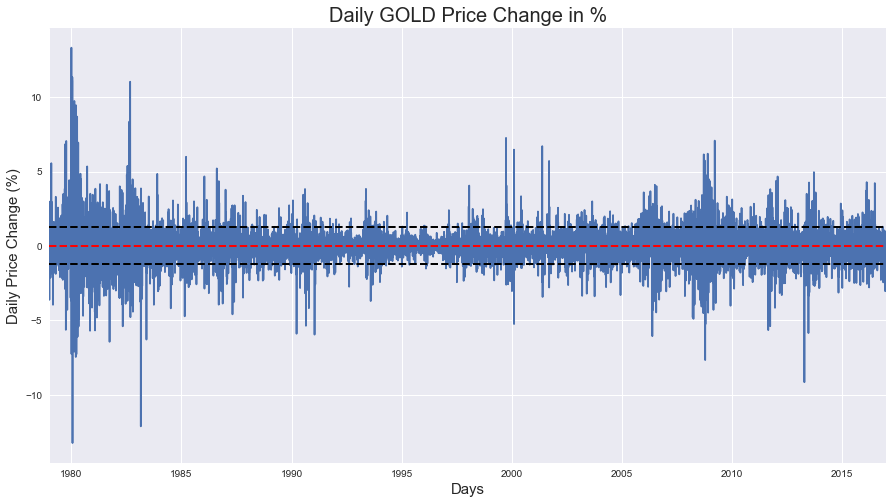

In [184]:
#plot daily change gold price, and make dashed lines for mean, 1 sigma(std)
daily_change.plot(figsize=(15, 8))
plt.title('Daily GOLD Price Change in %', fontsize=20)
plt.ylabel('Daily Price Change (%)', fontsize=15)
plt.xlabel('Days', fontsize=15)
plt.axhline(np.mean(daily_change), color='r', linestyle='dashed', linewidth=2)
plt.axhline(np.mean(daily_change)+np.std(daily_change), color='k', linestyle='dashed', linewidth=2)
plt.axhline(np.mean(daily_change)-np.std(daily_change), color='k', linestyle='dashed', linewidth=2)
plt.show();

>From above graphs, the data is not only non-stationary but also exponentially increasing.<br>
The magnitude of the day-to-day variations at early 1980's and present day, <br>
but there is no much changed in between mid 1980's to early 2000's. <br>
To deal with this, gold price need to apply a log transform to the original price.

In [7]:
#apply log transform to the original gold price
gold['log_adj_close'] = gold['adj_close'].apply(lambda x: np.log(x))

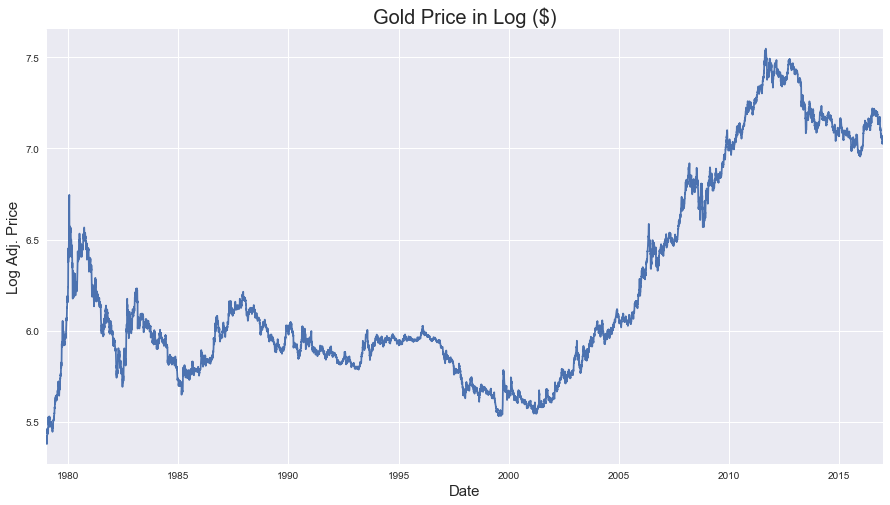

In [8]:
#plot logged gold price
plt.figure(figsize=(15, 8))
plt.title('Gold Price in Log ($)', fontsize=20)
plt.ylabel('Log Adj. Price', fontsize=15)
plt.xlabel('Date', fontsize=15)
gold['log_adj_close'].plot()
plt.show();

In [9]:
#statistical describe for gold adj. price.
gold['adj_close'].describe()

count    9915.000000
mean      599.164629
std       402.485564
min       216.900000
25%       344.300000
50%       396.300000
75%       682.500000
max      1895.000000
Name: adj_close, dtype: float64

In [10]:
#statistical describe for log gold adj. price.
gold['log_adj_close'].describe()

count    9915.000000
mean        6.221742
std         0.551773
min         5.379436
25%         5.841513
50%         5.982172
75%         6.525762
max         7.546974
Name: log_adj_close, dtype: float64

/Users/yun/anaconda/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).var()
  from ipykernel import kernelapp as app
/Users/yun/anaconda/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).var()
  app.launch_new_instance()


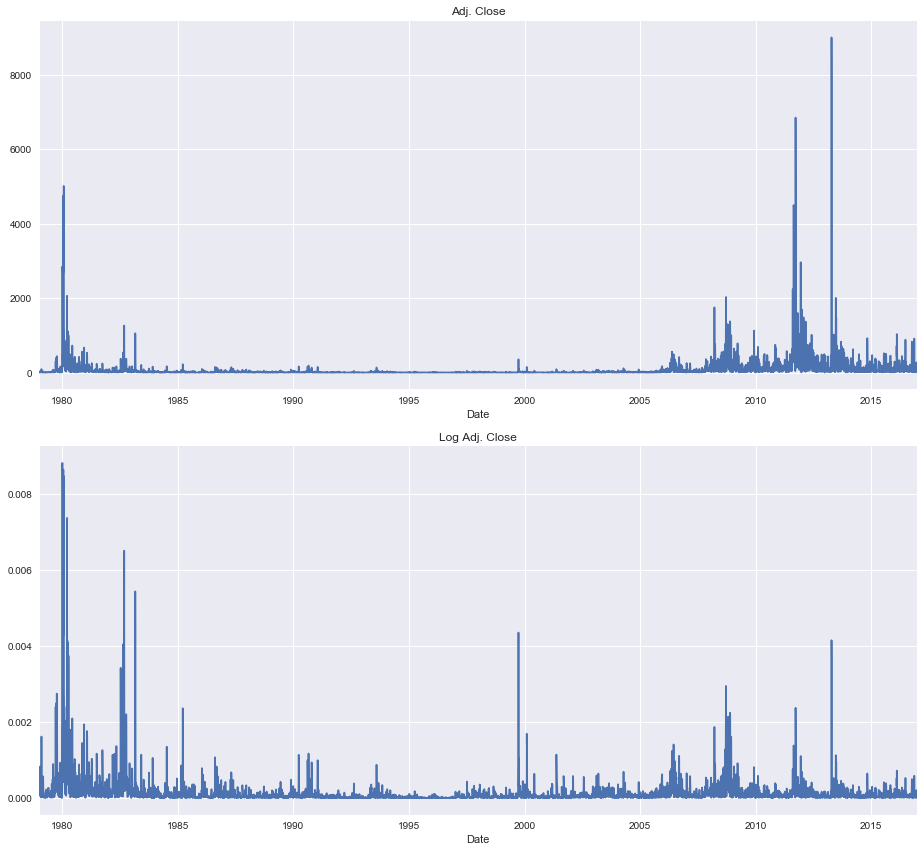

In [11]:
#compare variance original price and logged gold price
gold['adj_close_var'] = pd.rolling_var(gold['adj_close'], 5)  
gold['log_adj_close_var'] = pd.rolling_var(gold['log_adj_close'], 5)

fig, ax = plt.subplots(2, 1, figsize=(13, 12))
gold['adj_close_var'].plot(ax=ax[0], title='Adj. Close')
gold['log_adj_close_var'].plot(ax=ax[1], title='Log Adj. Close')  
fig.tight_layout()

>Logged Adj. Gold price is much better for variations, but it is still not clear.<br>
Therefore, the data set need to cut and use only last 10 years gold price<br>
which changes in the adj. gold price are clearly visible throughout the entire data set.

In [12]:
#cut the data set as ngold - 2006 ~ 2016 
last_11_years = -(261*11) + 1
ngold = gold[last_11_years:]
ngold.head()

,adj_close,log_adj_close,adj_close_var,log_adj_close_var
Date,,,,
2006-01-02,513.0,6.240276,45.300,0.000175
2006-01-03,530.0,6.272877,54.300,0.000200
2006-01-04,529.5,6.271933,84.200,0.000310
2006-01-05,524.8,6.263017,72.518,0.000267
2006-01-06,535.3,6.282827,70.957,0.000259


/Users/yun/anaconda/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).var()
  from ipykernel import kernelapp as app
/Users/yun/anaconda/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yun/anaconda/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).var()
  app.launch_new_instance()
/Users/yun/anaconda/envs/stats/lib/python3.6/site-package

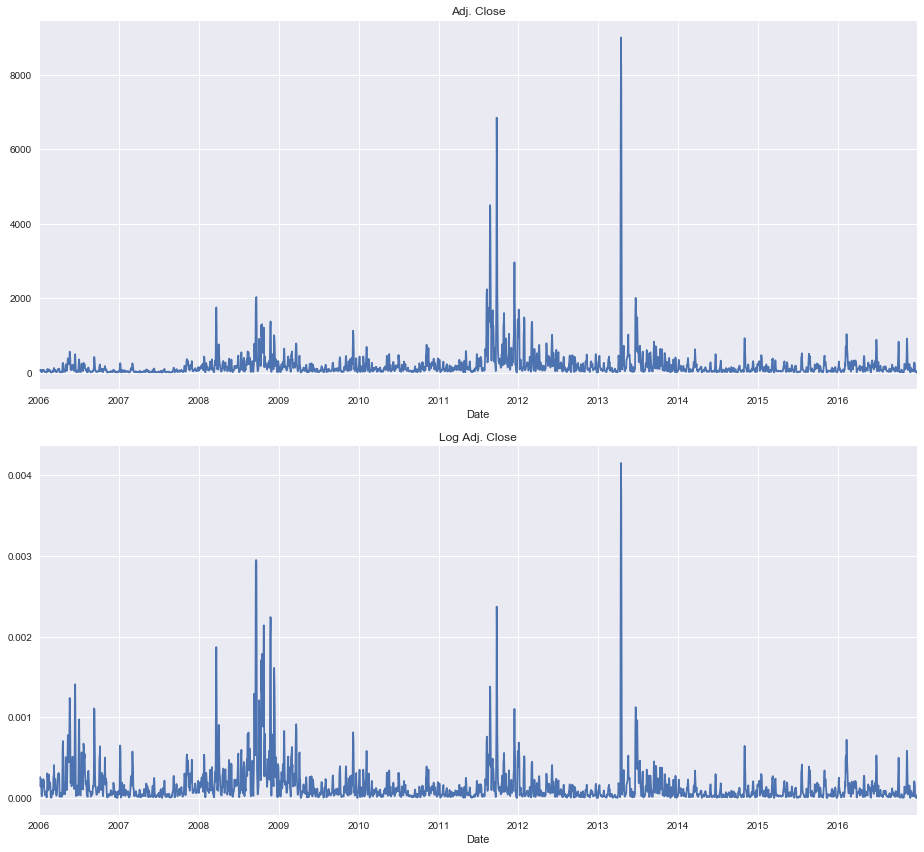

In [13]:
#compare variance original price and logged gold price for new gold data set since 2006
ngold['adj_close_var'] = pd.rolling_var(ngold['adj_close'], 5)  
ngold['log_adj_close_var'] = pd.rolling_var(ngold['log_adj_close'], 5)

fig, ax = plt.subplots(2, 1, figsize=(13, 12))  
ngold['adj_close_var'].plot(ax=ax[0], title='Adj. Close')  
ngold['log_adj_close_var'].plot(ax=ax[1], title='Log Adj. Close')  
fig.tight_layout() 

>It is clear for transformation has made the variance relatively constant.

### Set New GOLD Data set & Measure Correlation follow by Multiple Lag Size

In [14]:
ngold['ndaily_change'] = ngold['adj_close'].pct_change()
ngold['nlog_daily_change'] = ngold['log_adj_close'].pct_change()
len(ngold['ndaily_change']), len(ngold['nlog_daily_change'])

/Users/yun/anaconda/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/yun/anaconda/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(2870, 2870)

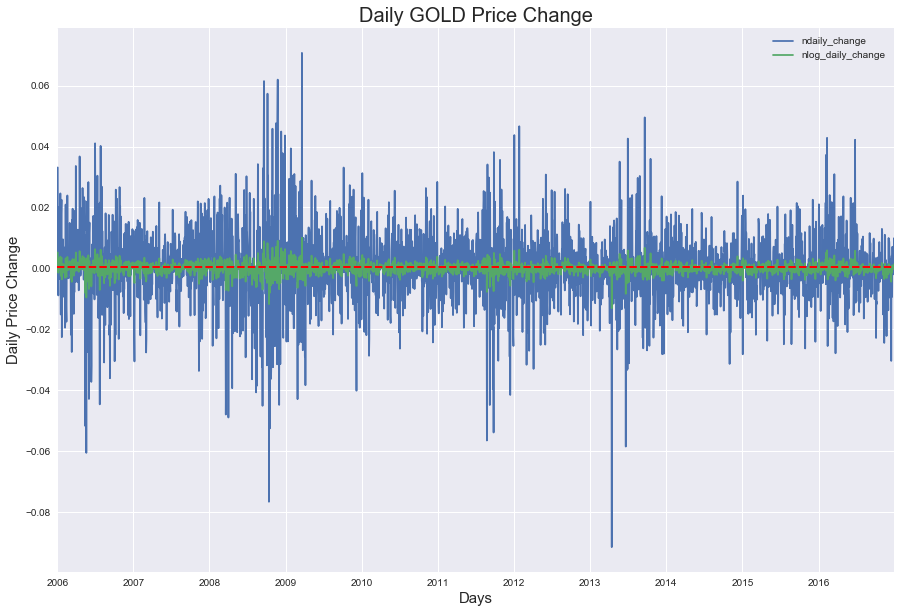

In [195]:
ngold['ndaily_change'].plot(figsize=(15, 10))
ngold['nlog_daily_change'].plot()
plt.title('Daily GOLD Price Change', fontsize=20)
plt.ylabel('Daily Price Change', fontsize=15)
plt.xlabel('Days', fontsize=15)
plt.axhline(np.mean(ngold['ndaily_change']), color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.show();

In [16]:
#apply auto correlation function for correlation in each window size.
nlag_corr = acf(ngold['nlog_daily_change'].iloc[1:], nlags=50)

In [18]:
#return max correlation values for lag days
print('Max Correlation Value for Lag Days: {} Days'.format(np.argmax(nlag_corr[1:])))

Max Correlation Value for Lag Days: 12 Days


In [19]:
#make shift logged daily change in order to compare correlation logged gold adj. price vs. 12days shifted adj. price
ngold['lag12'] = ngold['nlog_daily_change'].shift(12)

/Users/yun/anaconda/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [40]:
ngold[1:14]

,adj_close,log_adj_close,adj_close_var,log_adj_close_var,ndaily_change,nlog_daily_change,lag12
Date,,,,,,,
2006-01-03,530.0,6.272877,NaN,NaN,0.033138,0.005224,NaN
2006-01-04,529.5,6.271933,NaN,NaN,-0.000943,-0.000150,NaN
2006-01-05,524.8,6.263017,NaN,NaN,-0.008876,-0.001422,NaN
2006-01-06,535.3,6.282827,70.957,0.000259,0.020008,0.003163,NaN
2006-01-09,541.5,6.294343,40.747,0.000143,0.011582,0.001833,NaN
2006-01-10,543.5,6.298030,62.212,0.000218,0.003693,0.000586,NaN
2006-01-11,544.4,6.299684,66.235,0.000232,0.001656,0.000263,NaN
2006-01-12,542.5,6.296188,12.958,0.000045,-0.003490,-0.000555,NaN
2006-01-13,548.3,6.306823,6.848,0.000023,0.010691,0.001689,NaN


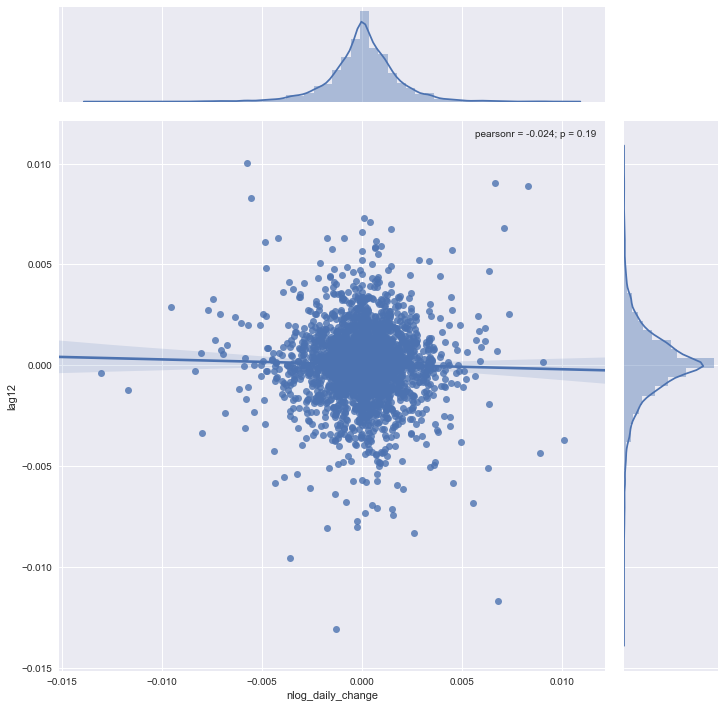

In [197]:
#plot correlation 12 days shifted price vs. original price
sns.jointplot('nlog_daily_change', 'lag12', ngold, kind='reg', size=10);  

>It seem like there is no correlation between adj. price and 12 days shifted (The Best Corr Value) adj. price.

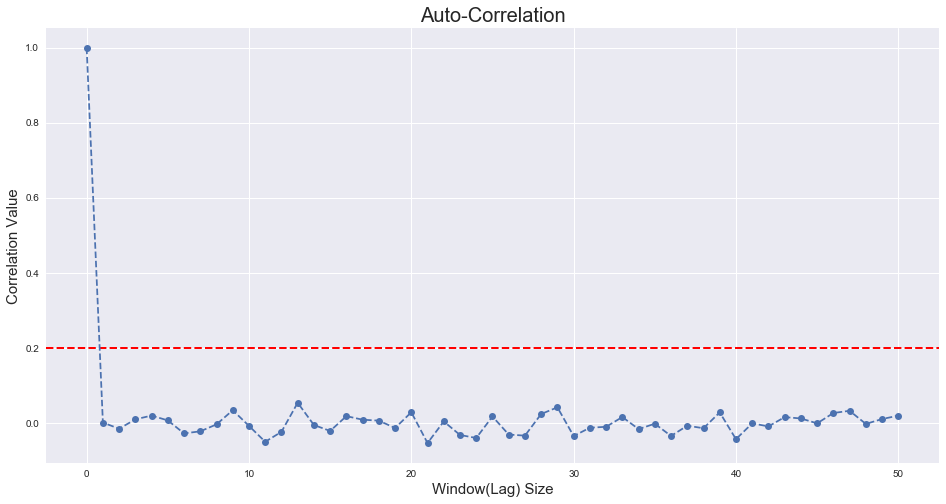

In [21]:
plt.figure(figsize=(16, 8))  
plt.title('Auto-Correlation', fontsize=20)
plt.ylabel('Correlation Value', fontsize=15)
plt.xlabel('Window(Lag) Size', fontsize=15)
plt.axhline(0.2, color='r', linestyle='dashed', linewidth=2)
plt.plot(nlag_corr, marker='o', linestyle='--');

>The auto correlation result shows that there is no significant (> 0.2) correlation. <br>
Therefore, the gold price follow a Random Walk.

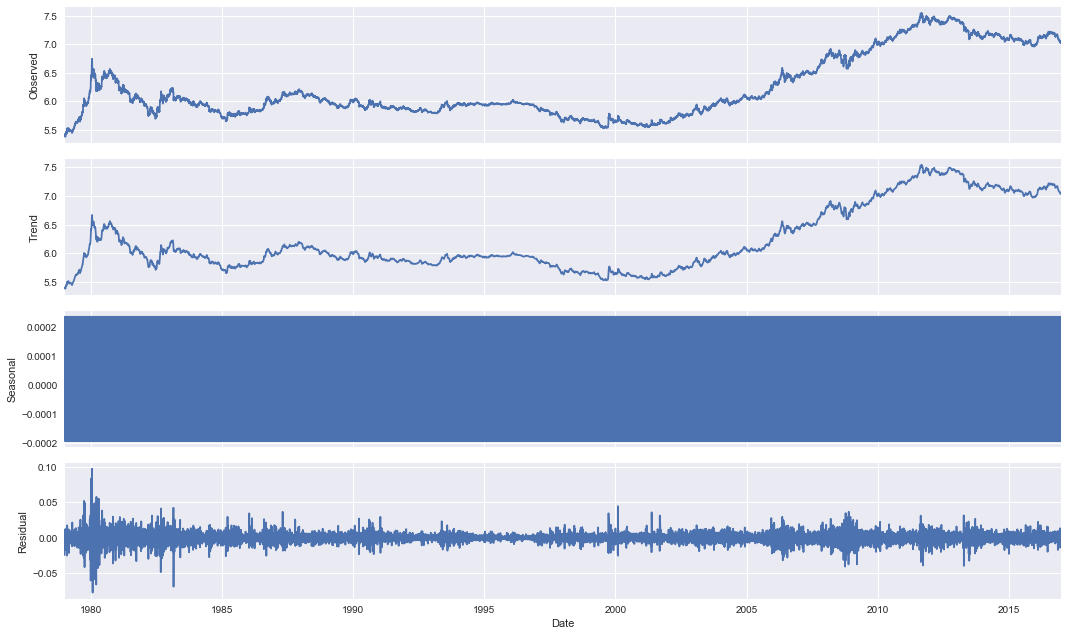

In [46]:
#decompose the data to see the seasonality with 38 years whole gold logged adj. price
rcParams['figure.figsize'] = 15, 9
gold_dec = sm.tsa.seasonal_decompose(gold['log_adj_close'])
fig = gold_dec.plot()

>There is no seasonality.

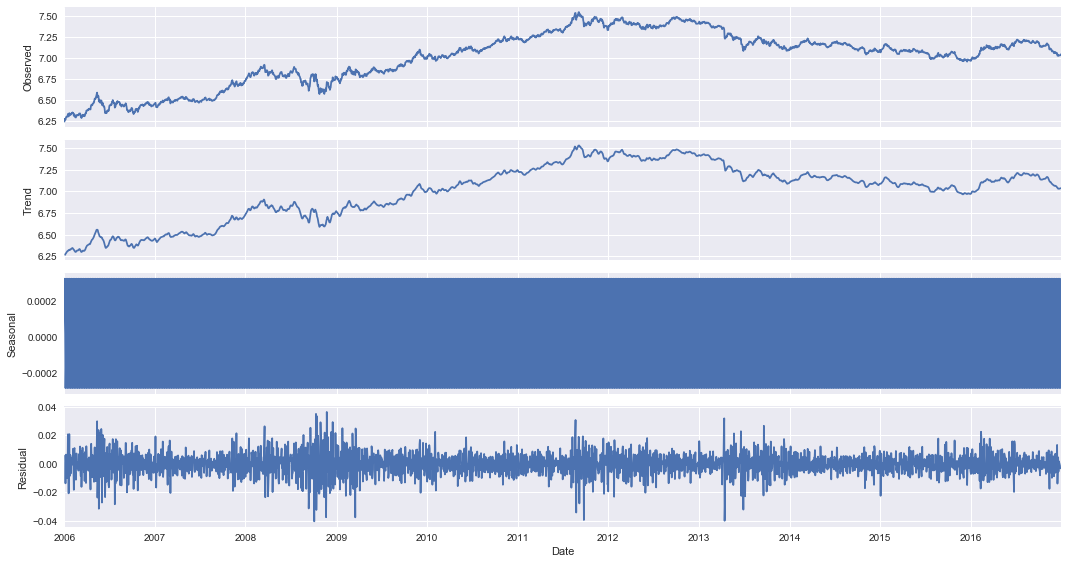

In [198]:
#decompose the data to see the seasonality with 11 years gold logged adj. price
rcParams['figure.figsize'] = 15, 8
gold_dec = sm.tsa.seasonal_decompose(ngold['log_adj_close'])
fig = gold_dec.plot()

>There is no seasonality, too.

In [141]:
#calculate mean of days in years in order to apply frequency for seasonality
uniq_years = sorted(list(set(ngold.index.year)))           #uniq. years (2004 ~ 2016)
year_count = []                                            #make empty list for counting days each year

for i in uniq_years:
    year_count.append(len(gold[gold.index.year == i]))
days_per_year = int(np.round(np.mean(year_count), 0))      #calculate the mean days in years

In [142]:
print('The Average Days per Years: {} Days'.format(days_per_year))

The Average Days per Years: 261 Days


In [143]:
#count days of years, and make list for days in 3, 1, 1/2, 1/4 years and 1 month in order to check the best seasonality
days_per_year = int(np.round(days_per_year))
days_per_half_year = int(np.round(days_per_year/2))
days_per_quarter_year = int(np.round(days_per_year/4))
month = int(np.round(days_per_year/12))
days_per_3years = int(days_per_year*3)
list_freq = [days_per_3years, days_per_year, days_per_half_year, days_per_quarter_year, month]
list_freq

[783, 261, 130, 65, 22]

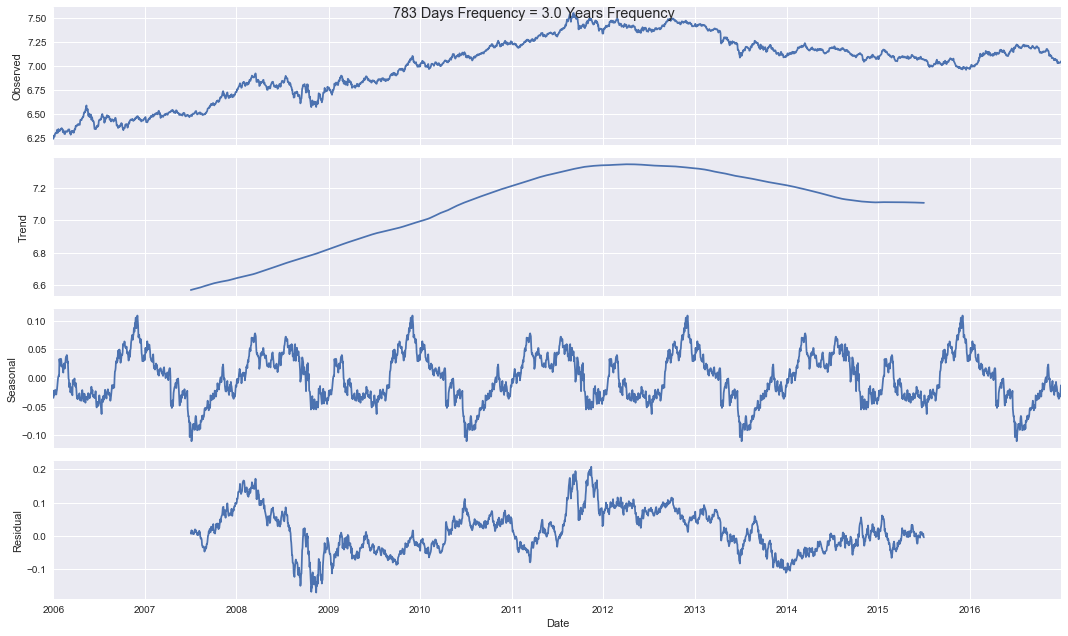

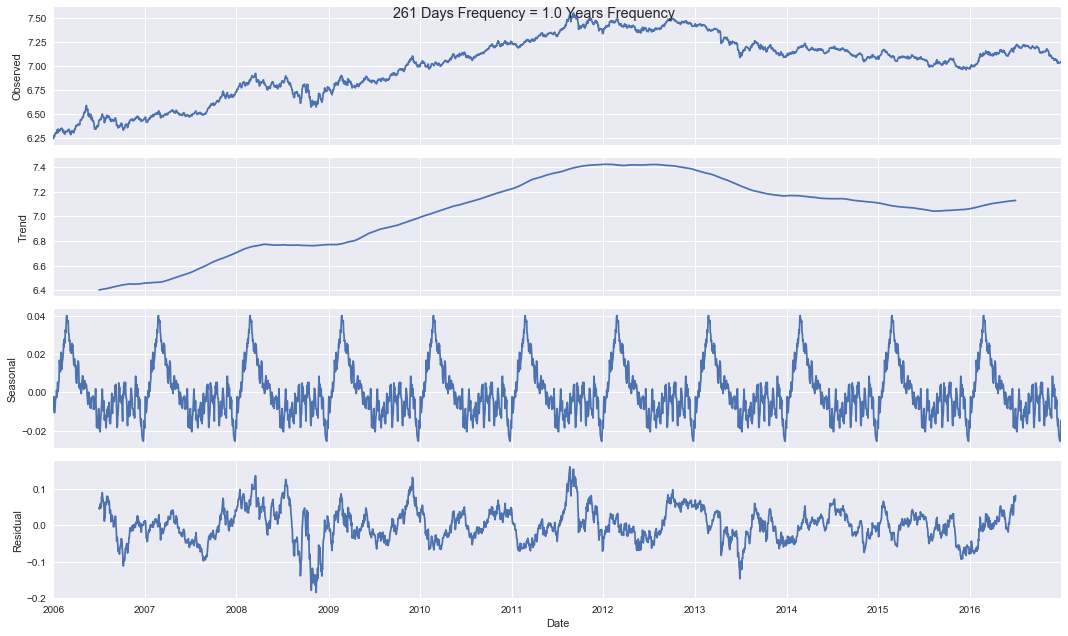

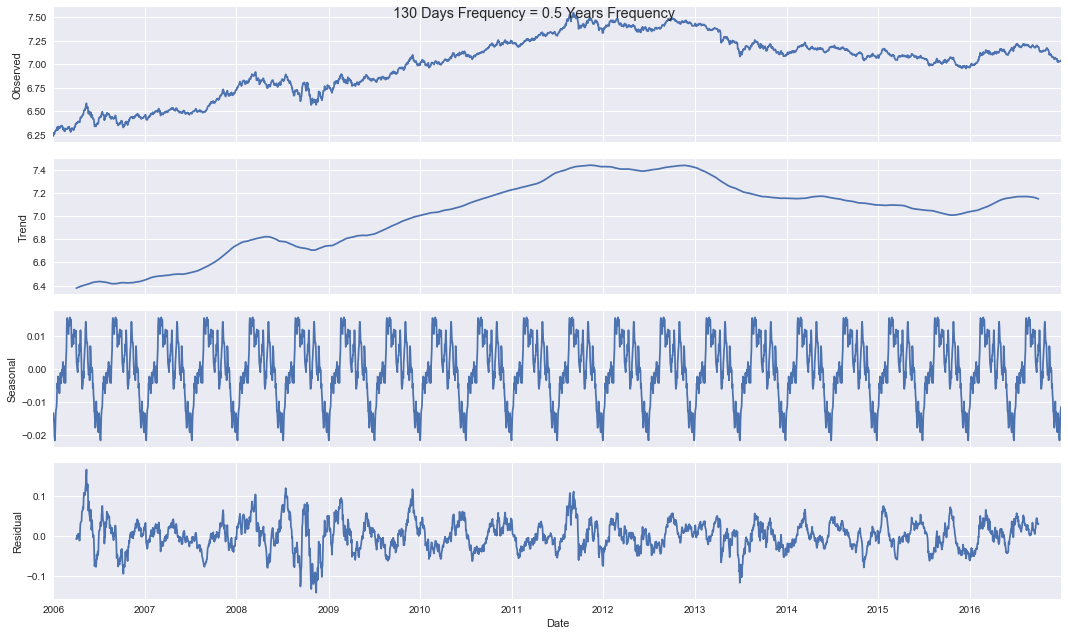

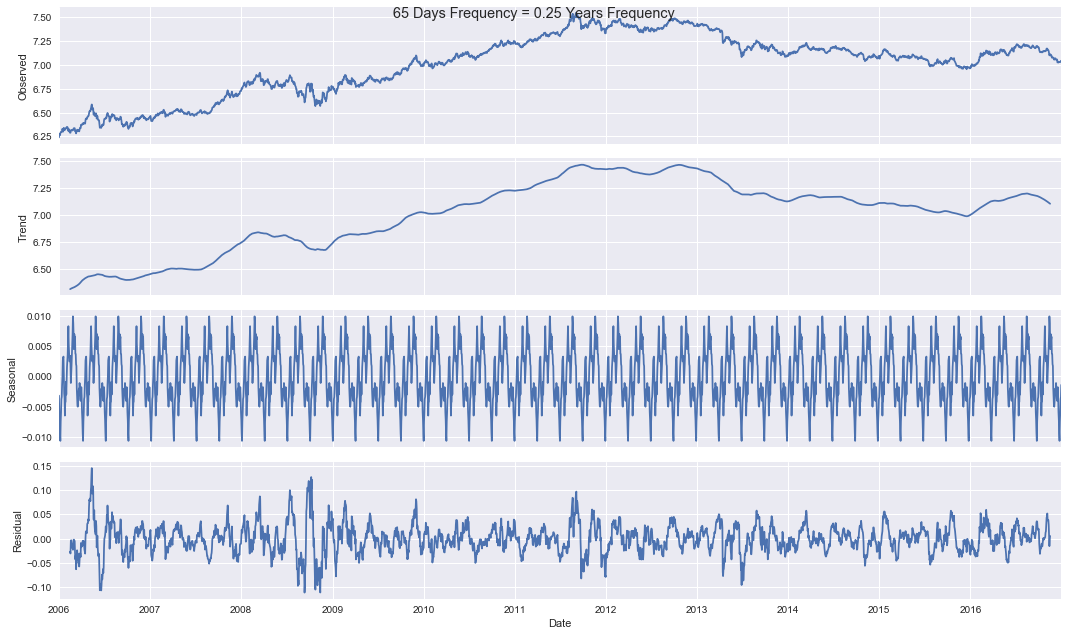

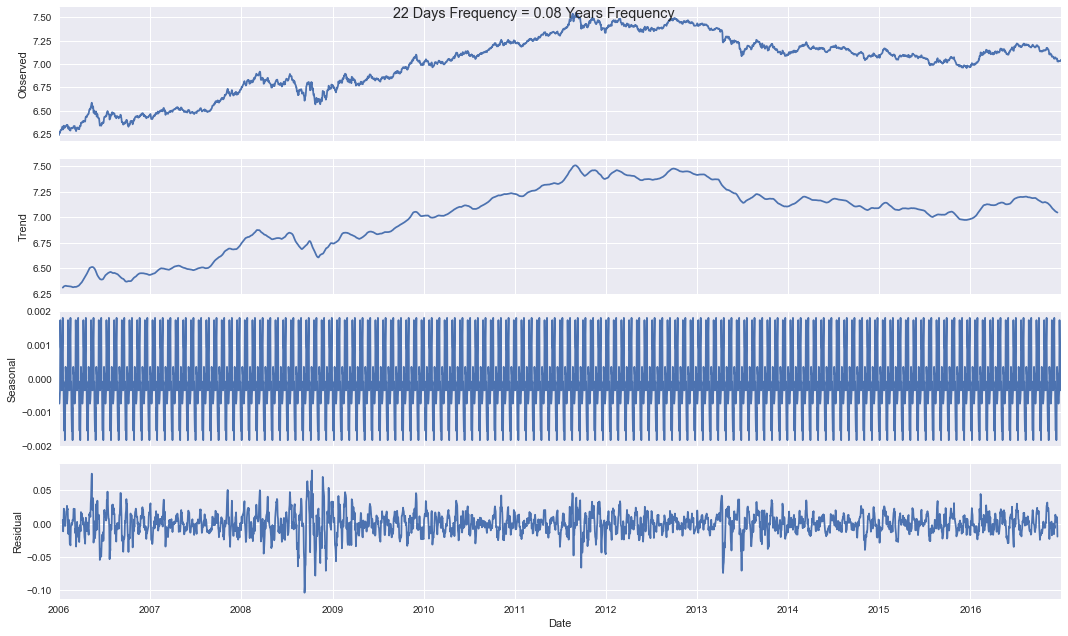

In [51]:
#decompose the data to see the seasonality by multiple window size days
rcParams['figure.figsize'] = 15, 9
for i in list_freq:
    #261 mean trading days in each year
    gold_dec = sm.tsa.seasonal_decompose(ngold['log_adj_close'], freq=i, model='additive') 
    fig = gold_dec.plot()
    fig.suptitle('{0} Days Frequency = {1} Years Frequency'.format(i, np.round(i/261, 2)))

>There is no seasonal trend for Gold adj. price.

#### There is no Correlation in multiple lag size, and also there is no seasonal pattern, so GOLD price follow Random walk. In other word, ARIMA forecast is not work for this data set.

/Users/yun/anaconda/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


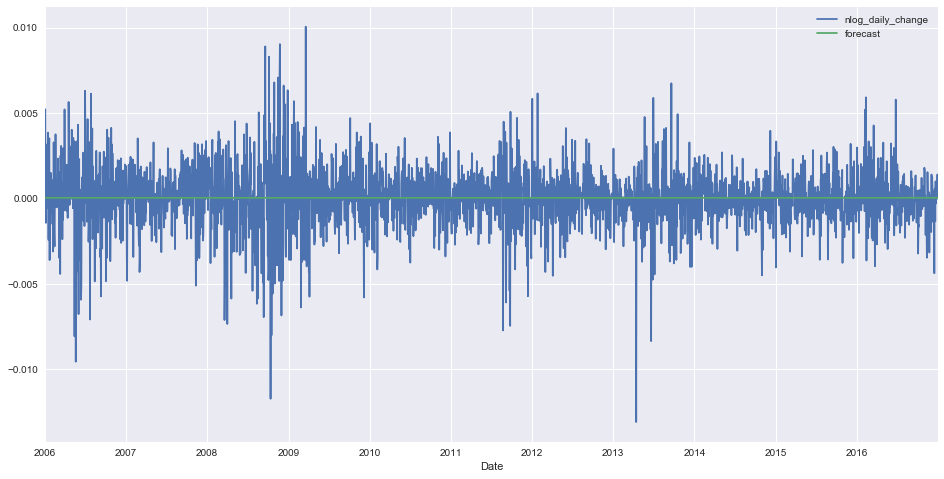

In [54]:
#Make sure ARIMA model is not work for this GOLD data
arima_model = sm.tsa.ARIMA(ngold['nlog_daily_change'].iloc[1:], order=(0, 0, 1))  
fit = arima_model.fit(disp=-1)  
ngold['forecast'] = fit.fittedvalues  
ngold[['nlog_daily_change', 'forecast']].plot(figsize=(16, 8)); 

### Random Walk (Monte Carlo) Simulation.

* Calculate Compound Annual Growth Rate (CAGR)
>$CAGR~(\%) = \Biggl(\Biggl(~\biggl(\dfrac{Ending~ Value}{Beginning~ Value}\biggr)^{\biggr(\dfrac{1}{Numbers~ of~ Years}\biggr)}\Biggl)~-1~\Biggl)~\times~100$

* Calculate Annual Volatility
>$Annual Volatility~(\%) = \Biggl(\biggl(std.\biggl(~\dfrac{Ending~ Value}{Beginning~ Value}~-1~\biggl)\biggl)~\times~\sqrt{Day~per~Years}\Biggl)~\times~100$

In [56]:
#number of years for CAGR calculation 
days = len(ngold.index)
num_of_years = days/days_per_year
num_of_years

10.996168582375478

In [65]:
def cal_exp(symbol, num_of_years, days_per_year=261):
    #calculate the compound annual growth rate(CAGR), it will use as mean return input(mu) 
    days = len(symbol.index)
    CAGR = ((((symbol['adj_close'][-1]) / symbol['adj_close'][0])) ** (1 / (num_of_years))) - 1
    print('Compound Annual Growth Rate(CAGR): {}%'.format(np.round(CAGR*100, 2)))
 
    #create a series of percentage return and calculate the annual volatility
    #symbol['per_return'] = symbol['adj_close'].pct_change()
    #volatility = symbol['per_return'].std()
    volatility = symbol['ndaily_change'].std()
    annual_volat = volatility * np.sqrt(days_per_year)
    print('Annual Volatility: {}%'.format(np.round(annual_volat*100, 2)))
    
    return CAGR, annual_volat

def cal_log_exp(symbol, num_of_years, days_per_year=261):
    #calculate the compound annual growth rate(CAGR), it will use as mean return input(mu) 
    days = len(symbol.index)
    CAGR = ((((symbol['log_adj_close'][-1]) / symbol['log_adj_close'][0])) ** (1 / (num_of_years))) - 1
    print('Compound Annual Growth Rate(CAGR): {}%'.format(np.round(CAGR*100, 2)))
 
    #create a series of percentage return and calculate the annual volatility
    #symbol['log_per_return'] = symbol['log_adj_close'].pct_change()
    #volatility = symbol['log_per_return'].std()
    volatility = symbol['nlog_daily_change'].std()
    annual_volat = volatility * np.sqrt(days_per_year)
    print('Annual Volatility: {}%'.format(np.round(annual_volat*100, 2)))
    
    return CAGR, annual_volat

In [154]:
#calculate GOLD Price
CAGR, annual_volat = cal_exp(ngold, num_of_years, days_per_year)

Compound Annual Growth Rate(CAGR): 7.58%
Annual Volatility: 19.92%


In [153]:
#calculate logged GOLD Price 
log_CAGR, log_annual_volat = cal_log_exp(ngold, num_of_years, days_per_year)

Compound Annual Growth Rate(CAGR): 1.11%
Annual Volatility: 2.89%


In [157]:
def MC_simulator(symbol, days, mu, vl, n_simulation):
    #Define Variables
    start_pri = symbol['adj_close'][-1]        #starting gold price
    #days = days_per_year                      #number of trading days
    #mu = CAGR                                 #annual return (compound annual growth)
    #vl = annual_volat                         #volatility
    simulations = []                           #make empty list for draw histgram whole simulation
    
    #make for loop for multiple times of simulation
    for _ in range(n_simulation):
        #make list of daily returns by random normal distribution
        day_return = np.random.normal(mu/days, vl/np.sqrt(days), days)+1

        #set start price and make list of price by random day return
        list_pri = [start_pri]
        for i in day_return:
            list_pri.append(list_pri[-1]*i)
    
        #plotting for list_pri prediction next 1 year (261 days).
        plt.plot(list_pri)
        
        #append last gold price of each simulation
        simulations.append(list_pri[-1])
        
    plt.title('GOLD Price Random Walk (Monte Carlo) Simulation', fontsize=20)
    plt.ylabel('Adj. Price', fontsize=15)
    plt.xlabel('Days', fontsize=15)
    plt.axhline(np.mean(simulations), color='r', linestyle='dashed', linewidth=3)
    plt.axhline(np.mean(simulations)+2*np.std(simulations), color='g', linestyle='dashed', linewidth=3)
    plt.axhline(np.mean(simulations)-2*np.std(simulations), color='g', linestyle='dashed', linewidth=3)
    plt.show()
    
    #draw histogram for last gold price for mutliple simulations
    plt.hist(simulations, bins=100)
    plt.title('Distribution for GOLD Price in Last Day from Random Walk Simulation', fontsize=20)
    plt.ylabel('Frequency', fontsize=15)
    plt.xlabel('Adj. Price', fontsize=15)
    plt.axvline(np.percentile(simulations, 5), color='r', linestyle='dashed', linewidth=2)
    plt.axvline(np.percentile(simulations, 95), color='r', linestyle='dashed', linewidth=2)
    plt.show()
    print('== Evaluation =====================================')
    print('* Mean Price: ${}'.format(np.round(np.mean(simulations), 2)))
    print('* Std. : ${}'.format(np.round(np.std(simulations))))
    print('* Std. Lower & Upper Adj. Price: [${0}, ${1}]'.format(np.round(np.mean(simulations)-2*np.std(simulations)),
                                                                 np.round(np.mean(simulations)+2*np.std(simulations))))
    print('---------------------------------------------------')
    print('*  5% Quantile Price: ${}'.format(np.round(np.percentile(simulations, 5))))
    print('* 95% Quantile Price: ${}'.format(np.round(np.percentile(simulations, 95))))
    print('---------------------------------------------------')
    print('* 25% Quantile Price: ${}'.format(np.round(np.percentile(simulations, 25))))
    print('* 75% Quantile Price: ${}'.format(np.round(np.percentile(simulations, 75))))
    print('===================================================')
    return simulations

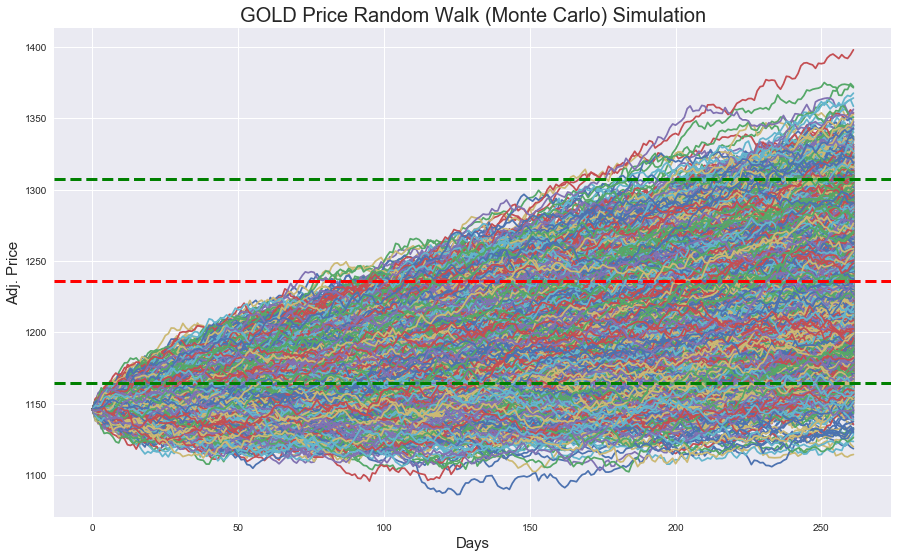

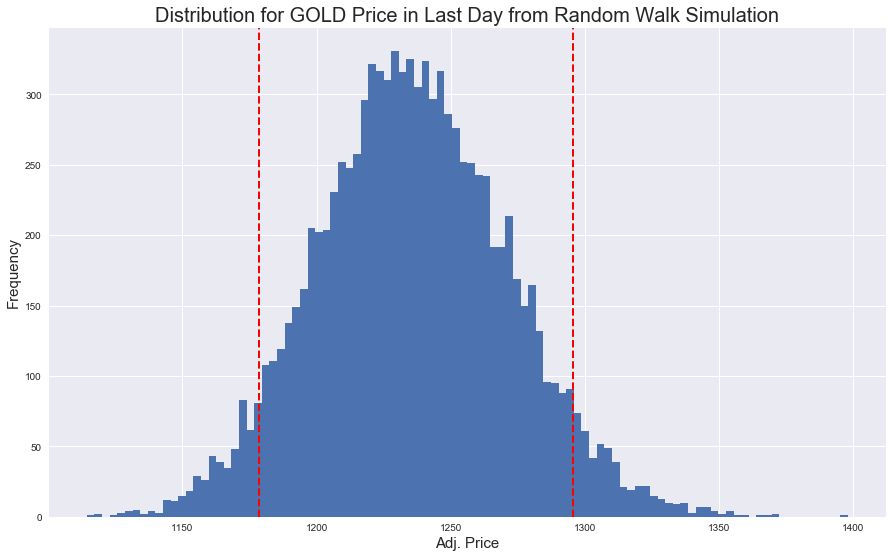

== Evaluation =====================================
* Mean Price: $1236.03
* Std. : $36.0
* Std. Lower & Upper Adj. Price: [$1165.0, $1307.0]
---------------------------------------------------
*  5% Quantile Price: $1179.0
* 95% Quantile Price: $1295.0
---------------------------------------------------
* 25% Quantile Price: $1212.0
* 75% Quantile Price: $1260.0


In [172]:
#Random walk simulation 10000 tims
mc_sim = MC_simulator(ngold, days_per_year, CAGR, log_annual_volat, 10000)

#### Compare Random Walk(Monte Carlo) Simulation vs. Original GOLD Price in 2017

In [164]:
#load the gold data(2017) in order to compare with random walk result
gold_2017 = pd.read_csv('gold_2017.csv')
gold_2017['Date'] = pd.DatetimeIndex(gold_2017['Date'])
gold_2017 = gold_2017.set_index('Date')
gold_2017.head()

,adj_close
Date,
2017-01-02,1145.9
2017-01-03,1151.0
2017-01-04,1164.3
2017-01-05,1176.7
2017-01-06,1175.9


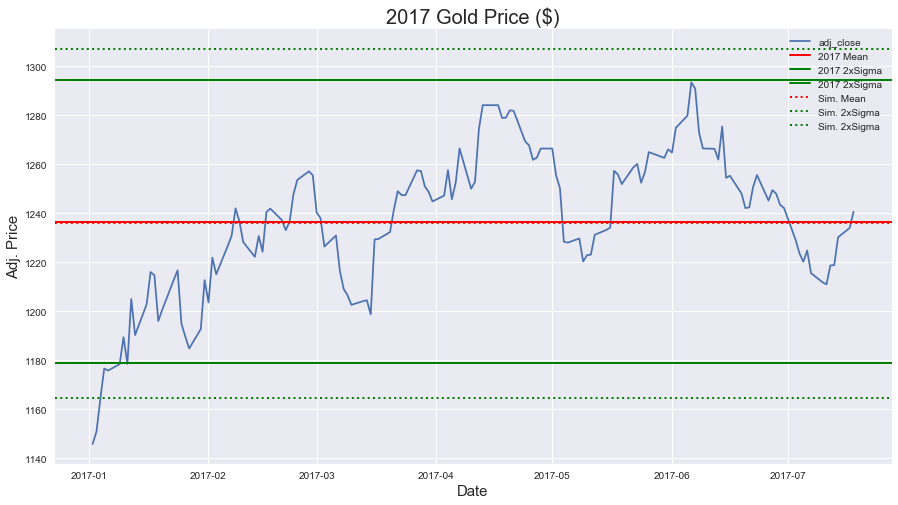

== Evaluation Original Price =======================
* Mean Price: $1236.61
* Std. : $29.0
* Std. Lower & Upper Adj. Price: [$1179.0, $1294.0]

== Evaluation Simulation Price =====================
* Mean Price: $1236.03
* Std. : $36.0
* Std. Lower & Upper Adj. Price: [$1165.0, $1307.0]


In [173]:
#plot gold price 2017
plt.figure(figsize=(15, 8))
plt.plot(gold_2017['adj_close'])
plt.title('2017 Gold Price ($)', fontsize=20)
plt.ylabel('Adj. Price', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.axhline(np.mean(gold_2017['adj_close']), color='r', linestyle='-', linewidth=2, label='2017 Mean')
plt.axhline(np.mean(gold_2017['adj_close'])+2*np.std(gold_2017['adj_close']), color='g', linestyle='-', linewidth=2, label='2017 2xSigma')
plt.axhline(np.mean(gold_2017['adj_close'])-2*np.std(gold_2017['adj_close']), color='g', linestyle='-', linewidth=2, label='2017 2xSigma')
plt.axhline(np.mean(mc_sim), color='r', linestyle=':', linewidth=2, label='Sim. Mean')
plt.axhline(np.mean(mc_sim)+2*np.std(mc_sim), color='g', linestyle=':', linewidth=2, label='Sim. 2xSigma')
plt.axhline(np.mean(mc_sim)-2*np.std(mc_sim), color='g', linestyle=':', linewidth=2, label='Sim. 2xSigma')
plt.legend()
plt.show()

print('== Evaluation Original Price =======================')
print('* Mean Price: ${}'.format(np.round(np.mean(gold_2017['adj_close']), 2)))
print('* Std. : ${}'.format(np.round(np.std(gold_2017['adj_close']))))
print('* Std. Lower & Upper Adj. Price: [${0}, ${1}]'.format(np.round(np.mean(gold_2017['adj_close'])-2*np.std(gold_2017['adj_close'])),
                                                             np.round(np.mean(gold_2017['adj_close'])+2*np.std(gold_2017['adj_close']))))
print('===================================================\n')
print('== Evaluation Simulation Price =====================')
print('* Mean Price: ${}'.format(np.round(np.mean(mc_sim), 2)))
print('* Std. : ${}'.format(np.round(np.std(mc_sim))))
print('* Std. Lower & Upper Adj. Price: [${0}, ${1}]'.format(np.round(np.mean(mc_sim)-2*np.std(mc_sim)),
                                                             np.round(np.mean(mc_sim)+2*np.std(mc_sim))))
print('===================================================')    